In [1]:
import pandas as pd
import numpy as np
import re

%matplotlib inline

In [2]:
def cleanup_hive_message(mess):
    if('TExecuteStatementResp' in mess):
        mess1 = re.sub('^(.*)infoMessages=\[' , '' , mess)
        mess2 = mess1.split(':')
        # print("HIVE_BEFORE" , mess)
        # print("HIVE_AFTER" , mess2)
        res = mess2[1] + " " +mess2[2] + " " +mess2[3]
        # print("HIVE_AFTER2" , res)
        return res
    return mess

def normalize_model_class_name(model_class_name):
    line1 = model_class_name
    line1 = line1.replace("sklearn2sql.Helpers.Caret_Model.cCaretClassifier_" , "caret.classifier.caret_class_")
    line1 = line1.replace("sklearn2sql.Helpers.Caret_Model.cCaretRegressor_" , "caret.regressor.caret_reg_")
    line1 = line1.replace("sklearn2sql.Helpers.Caret_Model.cCaretPreprocessor_" , "caret.preprocessor.caret_prep_")
    line1 = line1.replace("sklearn2sql.Helpers.Keras_Model.cKerasClassifier_" , "keras.classifier.keras_class_")
    line1 = line1.replace("sklearn2sql.Helpers.Keras_Model.cKerasRegressor_" , "keras.regressor.keras_reg_")
    return line1

def normalize_model_name(model_name):
    line1 = model_name
    line1 = line1.replace("cCaretClassifier_" , "caret_class_")
    line1 = line1.replace("cCaretRegressor_" , "caret_reg_")
    line1 = line1.replace("cCaretPreprocessor_" , "caret_prep_")
    line1 = line1.replace("cKerasClassifier_" , "keras_class_")
    line1 = line1.replace("cKerasRegressor_" , "keras_reg_")
    return line1


def read_bad_csv_file(name):
    rows = [];
    with open(name) as f:
        content = f.readlines()
    for line in content:
        line1 = line.replace("cx_" , "cx+")
        line1 = line1.replace("\n" , "")
        line1 = line1.replace("DataError" , "OperationalError")
        line1 = line1.replace("ProgrammingError" , "OperationalError")
        
        # line1 = re.sub('SQL.*$' , '',  line1)
        sql_error = ""
        
        if('Operational' in line1):
            #print("LINE1_BEFORE" , line1)
            if("[SQL" in line1):
                line1 = re.sub('OperationalError:.*OperationalError(.*)\[SQL.*$' , '____SQLERROR__\g<1>__SQLERROR____',  line1)
            else:
                line1 = re.sub('OperationalError:.*OperationalError(.*).*$' , '____SQLERROR__\g<1>__SQLERROR____',  line1)
                
            #print("LINE1_AFTER" , line1)
            sql_error = re.sub('.*____SQLERROR__', '',  line1)
            sql_error = re.sub('__SQLERROR____.*', '',  sql_error)
            sql_error = sql_error.replace(") (" , "")
            sql_error = sql_error.replace("\\n" , "")
            sql_error = sql_error.replace("\\" , "")
            sql_error = sql_error[:-2]
            #print("LINE1_AFTER" , sql_error)
        
        # line1 = re.sub('COMPARISON_FAILURE_TOO_MUCH_DIFFS.*$' , 'COMPARISON_FAILURE_TOO_MUCH_DIFFS',  line1)
        # line1 = re.sub('Table .* doesn.*$' , "Table doesn't exist",  line1)
        
        lRegex  = '\s+'
        fields = re.split(lRegex, line1);

        # print(fields)
        # for (i,f) in enumerate(fields):
        #    print(i, f)
        msg_field = " ".join(fields[11:12])
        if(sql_error != ""):
            msg_field = sql_error
        if(msg_field.startswith("'cTrainingError")):
            msg_field = " ".join(fields[11:-1])
        time_field = fields[-1].replace(")" , "")
        row = [fields[1], fields[2], fields[4], fields[3], fields[10], msg_field, time_field]
        rows = rows + [row]

    df = pd.DataFrame(rows);
    df.columns = ['Model' , 'dataset', 'est_dialect' , 'DSN' , 'status' , 'error_message' , 'elapsed_time']
    df['est_dialect'] = df['est_dialect'].str.replace("mysql" , "mariadb")
    df['Model'] = df['Model'].str.replace("\(\'" , "")
    df['Model'] = df['Model'].str.replace("\'," , "")
    df['Model'] = df['Model'].apply(normalize_model_name)
    df['error_message'] = df['error_message'].str.replace("None\)\)" , "SUCCESS")
    df['error_message'] = df['error_message'].str.replace("None\)," , "SUCCESS")
    df['error_message'] = df['error_message'].apply(lambda x : cleanup_hive_message(x))
    return df
    

In [3]:
#df = pd.read_csv('result.txt' , engine='python', sep='\s+', index_col=False,
#                 quotechar="'", header=None)

In [4]:
df = read_bad_csv_file('result.txt')

In [5]:
df.head()

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time
0,LGBMClassifier,"'DS_BENCH_C_200_22_10_D28EF166',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,28
1,LGBMClassifier,"'DS_BENCH_C_200_22_2_2E64DEB6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,11
2,LGBMClassifier,"'DS_BENCH_C_200_22_4_9802FBBD',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,15
3,LGBMClassifier,"'DS_BENCH_C_200_7_10_C3DE2F26',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,65
4,LGBMClassifier,"'DS_BENCH_C_200_7_2_F2617B35',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,47


In [6]:
df.Model.value_counts()

cCaretClassifier                    162
caret_class_glm                     162
LabelEncoder                        162
caret_class_rpart                   162
LabelBinarizer                      162
DummyClassifier                     160
ExtraTreeClassifier                 158
LogisticRegression                  157
PassiveAggressiveClassifier         157
LinearDiscriminantAnalysis          156
DecisionTreeClassifier              156
DummyClassifier_pipe                156
SGDClassifier                       155
RidgeClassifierCV                   155
ExtraTreeClassifier_pipe            155
Pipeline                            154
LogisticRegression_pipe             154
LinearSVC                           154
LogisticRegressionCV                154
PassiveAggressiveClassifier_pipe    154
LinearDiscriminantAnalysis_pipe     153
AdaBoostClassifier                  153
OneVsRestClassifier                 153
LogisticRegressionCV_pipe           153
RidgeClassifier                     153


In [7]:
def read_classes(name):
    lClasses = {}
    lCategories = {}
    rows = [];
    with open(name) as f:
        content = f.readlines()
    for line in content:
        line1 = line.replace("cGenerationWrapperFactory::createScikitObject() <class '" , "")
        line1 = line1.replace("'>\n" , "")
        line1 = normalize_model_class_name(line1)
        fq_class_name = line1
        short_class_name = fq_class_name.split(".")[-1]
        categeory = ".".join(fq_class_name.split(".")[0:2])
        lClasses[short_class_name] = fq_class_name
        lCategories[short_class_name] = categeory
    return (lClasses , lCategories)


In [8]:
(Classes , Categories) = read_classes("classes.txt")

In [9]:
Classes

{'LGBMClassifier': 'lightgbm.sklearn.LGBMClassifier',
 'LGBMRegressor': 'lightgbm.sklearn.LGBMRegressor',
 'cCaretClassifier': 'sklearn2sql.Helpers.Caret_Model.cCaretClassifier',
 'caret_class_ctree': 'caret.classifier.caret_class_ctree',
 'caret_class_ctree2': 'caret.classifier.caret_class_ctree2',
 'caret_class_glm': 'caret.classifier.caret_class_glm',
 'caret_class_glmnet': 'caret.classifier.caret_class_glmnet',
 'caret_class_nnet': 'caret.classifier.caret_class_nnet',
 'caret_class_rf': 'caret.classifier.caret_class_rf',
 'caret_class_rpart': 'caret.classifier.caret_class_rpart',
 'caret_class_svmRadial': 'caret.classifier.caret_class_svmRadial',
 'caret_class_xgbTree': 'caret.classifier.caret_class_xgbTree',
 'cCaretPreprocessor': 'sklearn2sql.Helpers.Caret_Model.cCaretPreprocessor',
 'caret_prep_center_scale': 'caret.preprocessor.caret_prep_center_scale',
 'caret_prep_ica': 'caret.preprocessor.caret_prep_ica',
 'caret_prep_pca': 'caret.preprocessor.caret_prep_pca',
 'cCaretRegres

In [10]:
def get_category(model_name):
    real_name = model_name
    if(model_name.endswith('_pipe')):
        real_name = model_name.replace("_pipe" , "")
    return Categories.get(real_name , "bad_category")

df['model_category'] = df['Model'].apply(get_category)
df.head()


,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category
0,LGBMClassifier,"'DS_BENCH_C_200_22_10_D28EF166',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,28,lightgbm.sklearn
1,LGBMClassifier,"'DS_BENCH_C_200_22_2_2E64DEB6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,11,lightgbm.sklearn
2,LGBMClassifier,"'DS_BENCH_C_200_22_4_9802FBBD',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,15,lightgbm.sklearn
3,LGBMClassifier,"'DS_BENCH_C_200_7_10_C3DE2F26',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,65,lightgbm.sklearn
4,LGBMClassifier,"'DS_BENCH_C_200_7_2_F2617B35',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,47,lightgbm.sklearn


In [11]:
df_model_datasets = pd.DataFrame(df[['Model' , 'dataset']].groupby(['Model'])['dataset'].value_counts())
datatsets_by_model = df_model_datasets.to_dict()['dataset'].keys()

In [12]:
# datatsets_by_model

In [13]:
datatsets_by_model_dict = {}
for k in datatsets_by_model:
    (m , ds) = k
    if(m not in datatsets_by_model_dict.keys()):
        datatsets_by_model_dict[m] = [ds]
    else:
        datatsets_by_model_dict[m] = datatsets_by_model_dict[m] + [ds]
        
# print(datatsets_by_model_dict)


In [14]:
missing_rows = []
dialects = df.est_dialect.unique()
print(dialects)

print("df.shape", df.shape , df.columns)
for dialect in dialects:
    df1 = df[df['est_dialect'] == dialect]
    # print("df1.shape", dialect, df1.shape , df1.columns)
    for (m , datasets) in datatsets_by_model_dict.items():
        lMissing = 0
        cond2 = (df1['Model'] == m)
        df2 = df1[cond2]
        # print("df2.shape", dialect, m , df2.shape, df2.columns)
        for ds in datasets:
            cond3 = (df2['dataset'] == ds)
            df3 = df2[cond3]
            # print("df3.shape", dialect, m, ds, df3.shape, df3.columns)
            if(df3.shape[0] == 0):
                # print("MISSING_DATA" , [dialect , m , ds])
                missing_rows = missing_rows + [[m , ds, dialect , 'no_dsn' , 'failure' , 'TIMEOUT' , None, get_category(m)]]
                lMissing = lMissing + 1
        if(lMissing >= (len(datasets) // 2)):
            print("MODEL_DATASETS_MISSING" , dialect, m, len(datasets) , lMissing)

missing_data = pd.DataFrame(missing_rows, columns=df.columns)
# missing_data

["'db2'," "'firebird'," "'monetdb'," "'mssql'," "'mariadb'," "'oracle',"
 "'pgsql'," "'sqltm'," "'teradata',"]
df.shape (20665, 8) Index(['Model', 'dataset', 'est_dialect', 'DSN', 'status', 'error_message',
       'elapsed_time', 'model_category'],
      dtype='object')
MODEL_DATASETS_MISSING 'db2', BaggingClassifier 18 9
MODEL_DATASETS_MISSING 'db2', BaggingClassifier_pipe 18 9
MODEL_DATASETS_MISSING 'db2', keras_class_GRU 18 9
MODEL_DATASETS_MISSING 'db2', keras_class_GRU_pipe 18 9
MODEL_DATASETS_MISSING 'firebird', AdaBoostClassifier 18 9
MODEL_DATASETS_MISSING 'firebird', AdaBoostClassifier_pipe 18 11
MODEL_DATASETS_MISSING 'firebird', BaggingClassifier 18 13
MODEL_DATASETS_MISSING 'firebird', BaggingClassifier_pipe 18 13
MODEL_DATASETS_MISSING 'firebird', BernoulliNB 18 13
MODEL_DATASETS_MISSING 'firebird', BernoulliNB_pipe 18 13
MODEL_DATASETS_MISSING 'firebird', CalibratedClassifierCV 18 13
MODEL_DATASETS_MISSING 'firebird', CalibratedClassifierCV_pipe 18 14
MODEL_DATASETS_MISSI

In [15]:
missing_data.head()

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category
0,BaggingClassifier,"'DS_BENCH_C_200_22_10_D28EF166',","'db2',",no_dsn,failure,TIMEOUT,None,sklearn.ensemble
1,BaggingClassifier,"'DS_BENCH_C_200_22_2_2E64DEB6',","'db2',",no_dsn,failure,TIMEOUT,None,sklearn.ensemble
2,BaggingClassifier,"'DS_BENCH_C_200_22_4_9802FBBD',","'db2',",no_dsn,failure,TIMEOUT,None,sklearn.ensemble
3,BaggingClassifier,"'DS_BENCH_C_200_82_10_EA8E6ACF',","'db2',",no_dsn,failure,TIMEOUT,None,sklearn.ensemble
4,BaggingClassifier,"'DS_BENCH_C_200_82_2_7B21C547',","'db2',",no_dsn,failure,TIMEOUT,None,sklearn.ensemble


In [16]:
df = df.append(missing_data , ignore_index=True)

In [17]:
df[df.error_message == "'"].head(200)

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category


In [18]:
df.shape

(22224, 8)

In [19]:
df.est_dialect.value_counts()

'oracle',      2470
'teradata',    2470
'pgsql',       2470
'sqltm',       2470
'mssql',       2470
'firebird',    2470
'mariadb',     2470
'db2',         2470
'monetdb',     2464
Name: est_dialect, dtype: int64

In [20]:
#df0[df0.ds == numpy.na]
df_errors = df[(df.error_message != 'SUCCESS')]
indices = df_errors.error_message.apply(lambda x : 'dialect' not in x)
df_errors = df_errors[indices]


In [21]:
msg_by_estim_and_dsn = pd.DataFrame(df_errors.groupby(['est_dialect'])['error_message'].value_counts())

In [22]:
msg_by_estim_and_dsn.sort_values(by='error_message' , ascending=False)

/home/antoine/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'error_message' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


,,error_message
est_dialect,error_message,
"'firebird',",TIMEOUT,785
"'monetdb',",'IntegrityError:COMMIT:,488
"'firebird',","""DatabaseError:('Error",410
"'monetdb',",TIMEOUT,347
"'teradata',",TIMEOUT,181
"'monetdb',","""Exception:CODE_GENERATION_NOT_IMPLEMENTED",164
"'teradata',","""Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS",122
"'oracle',","""Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS",122
"'sqltm',","""Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS",117


In [23]:
pd.DataFrame(df.error_message.value_counts())

,error_message
SUCCESS,17469
TIMEOUT,1559
"""Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS",843
'IntegrityError:COMMIT:,488
"""Exception:CODE_GENERATION_NOT_IMPLEMENTED",452
"""DatabaseError:('Error",410
"""cTrainingError:Exception:TRAIN_FAILED",189
"'cTrainingError:Exception:CODE_GENERATION_NOT_IMPLEMENTED cCaretClassifier'),",162
"'cTrainingError:Exception:CODE_GENERATION_NOT_IMPLEMENTED cCaretPreprocessor'),",108
'DatabaseError:(fdb.fbcore.DatabaseError),81


In [24]:

lGroupBy = df[df.status == 'failure'].groupby(['error_message'])

In [25]:
#lGroupBy['rows'].describe()

In [26]:
lComparisonErrorMessage = '"Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS'
real_errors = df[df.error_message.str.contains(lComparisonErrorMessage)]
real_errors.Model.value_counts()

keras_class_GRU_pipe               107
keras_class_SimpleRNN_pipe         106
keras_class_SimpleRNN               90
keras_class_LSTM_pipe               84
caret_class_svmRadial               70
DummyClassifier                     54
DummyClassifier_pipe                49
caret_class_nnet                    43
caret_class_xgbTree                 28
ExtraTreesClassifier_pipe           26
OrdinalEncoder                      26
ComplementNB                        17
ComplementNB_pipe                   17
FastICA                             16
LinearDiscriminantAnalysis_pipe     14
FactorAnalysis                      12
ExtraTreesClassifier                10
ExtraTreeClassifier_pipe             9
XGBRegressor                         8
AdaBoostClassifier_pipe              8
AdaBoostClassifier                   6
QuantileTransformer                  5
BaggingClassifier                    5
LGBMClassifier_pipe                  4
ExtraTreeClassifier                  4
BaggingClassifier_pipe   

In [27]:
lNotImplementedMessage = 'CODE_GENERATION_NOT_IMPLEMENTED'

not_impl_errors = df[df.error_message.str.contains(lNotImplementedMessage)]
not_impl_errors.Model.value_counts()


cCaretClassifier              162
cCaretPreprocessor            108
MiniBatchSparsePCA            108
SparsePCA                      96
LatentDirichletAllocation      54
NMF                            54
cCaretRegressor                54
keras_class_GRU                18
keras_class_GRU_pipe           18
keras_class_LSTM_pipe          18
keras_class_SimpleRNN_pipe     18
keras_class_SimpleRNN          18
keras_class_LSTM               17
keras_reg_LSTM                  6
keras_reg_LSTM_pipe             6
keras_reg_GRU_pipe              6
keras_reg_GRU                   6
keras_reg_SimpleRNN_pipe        5
keras_reg_SimpleRNN             4
Name: Model, dtype: int64

In [28]:
# database related errors
def is_other_error(df1):
    return df1.error_message.apply(lambda x : not x in ['SUCCESS', lComparisonErrorMessage, lNotImplementedMessage])

# other_errors = df.error_message.apply(lambda x : 1 if is_other_error(x)  else 0)
other_errors = df[is_other_error(df)]
other_errors.Model.value_counts()


cCaretClassifier                    162
caret_class_glm                     162
SparsePCA                           108
MiniBatchSparsePCA                  108
cCaretPreprocessor                  108
caret_class_xgbTree                  96
keras_class_LSTM_pipe                78
keras_class_LSTM                     78
caret_class_rf                       71
caret_class_glmnet                   67
keras_class_GRU                      57
keras_class_SimpleRNN_pipe           56
keras_class_GRU_pipe                 55
NMF                                  54
cCaretRegressor                      54
LatentDirichletAllocation            54
NuSVC_pipe                           53
caret_class_svmRadial                51
keras_class_SimpleRNN                51
NuSVC                                49
caret_class_nnet                     46
GradientBoostingClassifier_pipe      43
SVC                                  40
GaussianNB                           39
SVC_pipe                             39


In [29]:
# df.pivot(index = 'Model', values='status' , columns='est_dialect')

In [30]:
df.columns

Index(['Model', 'dataset', 'est_dialect', 'DSN', 'status', 'error_message',
       'elapsed_time', 'model_category'],
      dtype='object')

In [31]:
df.head()

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category
0,LGBMClassifier,"'DS_BENCH_C_200_22_10_D28EF166',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,28,lightgbm.sklearn
1,LGBMClassifier,"'DS_BENCH_C_200_22_2_2E64DEB6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,11,lightgbm.sklearn
2,LGBMClassifier,"'DS_BENCH_C_200_22_4_9802FBBD',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,15,lightgbm.sklearn
3,LGBMClassifier,"'DS_BENCH_C_200_7_10_C3DE2F26',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,65,lightgbm.sklearn
4,LGBMClassifier,"'DS_BENCH_C_200_7_2_F2617B35',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,47,lightgbm.sklearn


In [32]:
df['status'] = df['status'].apply(lambda x : 1 if('failure' in x) else 0)
df['status_2'] = df['status'].apply(lambda x : 1)


In [33]:
def strip_punc(x):
    x = x .replace("'" , "")
    x = x .replace("(" , "")
    x = x .replace("," , "")
    return x

df['dialect'] = df['est_dialect'].apply(lambda x : strip_punc(x))
df['Model'] = df['Model'].apply(lambda x : strip_punc(x))
df['dataset'] = df['dataset'].apply(lambda x : strip_punc(x))
df = df[df['model_category'] != 'sklearn.dummy']
df = df[~df['error_message'].str.contains(lNotImplementedMessage)]



In [34]:
df.head()

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category,status_2,dialect
0,LGBMClassifier,DS_BENCH_C_200_22_10_D28EF166,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,28,lightgbm.sklearn,1,db2
1,LGBMClassifier,DS_BENCH_C_200_22_2_2E64DEB6,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,11,lightgbm.sklearn,1,db2
2,LGBMClassifier,DS_BENCH_C_200_22_4_9802FBBD,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,15,lightgbm.sklearn,1,db2
3,LGBMClassifier,DS_BENCH_C_200_7_10_C3DE2F26,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,65,lightgbm.sklearn,1,db2
4,LGBMClassifier,DS_BENCH_C_200_7_2_F2617B35,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,47,lightgbm.sklearn,1,db2


In [35]:
# How many tests were used for each model category
pvt_count = pd.pivot_table(df, index='model_category', values='status_2' , columns=['dialect'],  aggfunc=[np.sum], margins=True)
pvt_count.head(pvt_count.shape[0])


sum                                        \
dialect                         db2 firebird mariadb monetdb mssql oracle   
model_category                                                              
caret.classifier                160      160     160     160   160    160   
caret.preprocessor               36       36      36      36    36     36   
caret.regressor                  54       54      54      54    54     54   
keras.classifier                144      144     144      37   144    144   
keras.regressor                  48       48      48      15    48     48   
lightgbm.sklearn                 48       48      48      48    48     48   
sklearn.calibration              36       36      36      36    36     36   
sklearn.covariance               12       12      12      12    12     12   
sklearn.decomposition            72       72      72      84    72     72   
sklearn.discriminant_analysis    36       36      36      36    36     36   
sklearn.ensemble                252      252     252     252   252    252   
sklearn.feature_selection       108      108     108     108   108    108   
sklearn.impute                   24       24      24      24    24     24   
sklearn.kernel_ridge             12       12      12      12    12     12   
sklearn.linear_model            492      492     492     492   492    492   
sklearn.multiclass               72       72      72      72    72     72   
sklearn.naive_bayes             144      144     144     144   144    144   
sklearn.neural_network           48       48      48      48    48     48   
sklearn.pipeline                 48       48      48      48    48     48   
sklearn.preprocessing           180      180     180     174   180    180   
sklearn.random_projection        24       24      24      24    24     24   
sklearn.svm                     156      156     156     156   156    156   
sklearn.tree                     96       96      96      96    96     96   
xgboost.sklearn                  48       48      48      48    48     48   
All                            2350     2350    2350    2216  2350   2350   

                                                           
dialect                       pgsql sqltm teradata    All  
model_category                                             
caret.classifier                160   160      160   1440  
caret.preprocessor               36    36       36    324  
caret.regressor                  54    54       54    486  
keras.classifier                144   144      144   1189  
keras.regressor                  48    48       48    399  
lightgbm.sklearn                 48    48       48    432  
sklearn.calibration              36    36       36    324  
sklearn.covariance               12    12       12    108  
sklearn.decomposition            72    72       72    660  
sklearn.discriminant_analysis    36    36       36    324  
sklearn.ensemble                252   252      252   2268  
sklearn.feature_selection       108   108      108    972  
sklearn.impute                   24    24       24    216  
sklearn.kernel_ridge             12    12       12    108  
sklearn.linear_model            492   492      492   4428  
sklearn.multiclass               72    72       72    648  
sklearn.naive_bayes             144   144      144   1296  
sklearn.neural_network           48    48       48    432  
sklearn.pipeline                 48    48       48    432  
sklearn.preprocessing           180   180      180   1614  
sklearn.random_projection        24    24       24    216  
sklearn.svm                     156   156      156   1404  
sklearn.tree                     96    96       96    864  
xgboost.sklearn                  48    48       48    432  
All                            2350  2350     2350  21016

In [36]:
pvt = pd.pivot_table(df, index='model_category', values='status' , columns=['dialect'],  aggfunc=[np.mean], margins=True)

In [37]:
pvt.head(pvt.shape[0])

mean                                \
dialect                             db2  firebird   mariadb   monetdb   
model_category                                                          
caret.classifier               0.381250  0.581250  0.343750  0.562500   
caret.preprocessor             0.000000  0.111111  0.027778  0.444444   
caret.regressor                0.074074  0.296296  0.037037  0.222222   
keras.classifier               0.548611  0.993056  0.548611  0.648649   
keras.regressor                0.041667  0.895833  0.062500  0.466667   
lightgbm.sklearn               0.020833  0.937500  0.020833  0.583333   
sklearn.calibration            0.000000  0.944444  0.000000  0.833333   
sklearn.covariance             0.250000  0.416667  0.166667  0.333333   
sklearn.decomposition          0.041667  0.222222  0.027778  0.309524   
sklearn.discriminant_analysis  0.083333  0.555556  0.055556  0.138889   
sklearn.ensemble               0.083333  0.904762  0.174603  0.595238   
sklearn.feature_selection      0.000000  0.000000  0.000000  0.000000   
sklearn.impute                 0.000000  0.000000  0.000000  0.500000   
sklearn.kernel_ridge           0.000000  0.833333  0.000000  0.000000   
sklearn.linear_model           0.006098  0.400407  0.002033  0.327236   
sklearn.multiclass             0.000000  0.888889  0.000000  0.583333   
sklearn.naive_bayes            0.048611  0.868056  0.027778  0.902778   
sklearn.neural_network         0.000000  0.854167  0.000000  0.520833   
sklearn.pipeline               0.000000  0.333333  0.000000  0.270833   
sklearn.preprocessing          0.088889  0.111111  0.033333  0.212644   
sklearn.random_projection      0.000000  0.166667  0.000000  0.000000   
sklearn.svm                    0.019231  0.756410  0.000000  0.487179   
sklearn.tree                   0.010417  0.447917  0.000000  0.187500   
xgboost.sklearn                0.020833  0.937500  0.020833  0.645833   
All                            0.088511  0.565957  0.086383  0.422834   

                                                                       \
dialect                           mssql    oracle     pgsql     sqltm   
model_category                                                          
caret.classifier               0.406250  0.556250  0.568750  0.331250   
caret.preprocessor             0.027778  0.444444  0.000000  0.000000   
caret.regressor                0.185185  0.074074  0.148148  0.111111   
keras.classifier               0.548611  0.472222  0.548611  0.486111   
keras.regressor                0.020833  0.041667  0.062500  0.041667   
lightgbm.sklearn               0.000000  0.020833  0.000000  0.000000   
sklearn.calibration            0.000000  0.000000  0.000000  0.000000   
sklearn.covariance             0.166667  0.083333  0.166667  0.166667   
sklearn.decomposition          0.027778  0.027778  0.027778  0.027778   
sklearn.discriminant_analysis  0.027778  0.055556  0.027778  0.027778   
sklearn.ensemble               0.007937  0.007937  0.007937  0.007937   
sklearn.feature_selection      0.000000  0.000000  0.000000  0.000000   
sklearn.impute                 0.000000  0.000000  0.000000  0.000000   
sklearn.kernel_ridge           0.000000  0.000000  0.000000  0.000000   
sklearn.linear_model           0.002033  0.002033  0.004065  0.002033   
sklearn.multiclass             0.000000  0.000000  0.000000  0.000000   
sklearn.naive_bayes            0.027778  0.027778  0.027778  0.027778   
sklearn.neural_network         0.000000  0.000000  0.000000  0.000000   
sklearn.pipeline               0.000000  0.000000  0.000000  0.000000   
sklearn.preprocessing          0.033333  0.033333  0.022222  0.077778   
sklearn.random_projection      0.000000  0.000000  0.000000  0.000000   
sklearn.svm                    0.000000  0.275641  0.000000  0.000000   
sklearn.tree                   0.000000  0.135417  0.000000  0.000000   
xgboost.sklearn                0.020833  0.020833  0.020833  0.020833   
All                

In [38]:
df.to_csv('report_extensive_tests.csv')

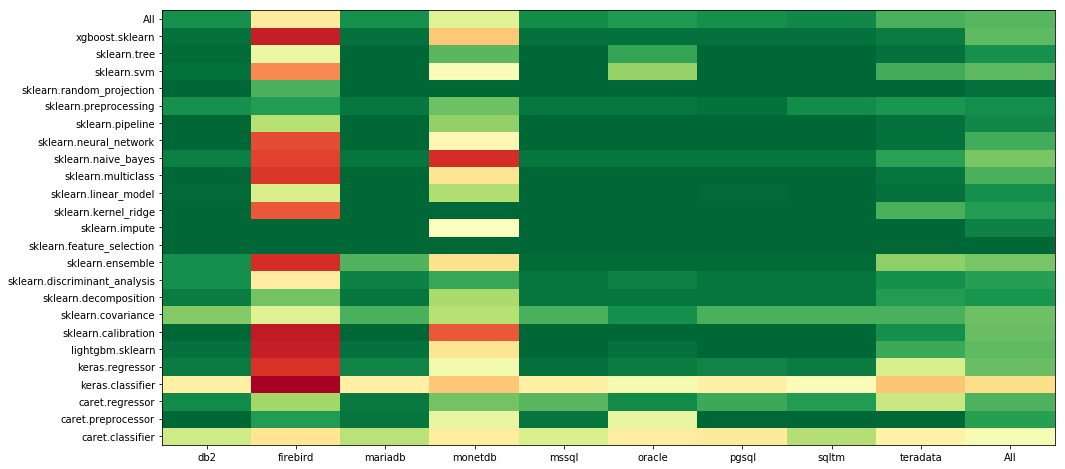

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.pcolor(1-pvt, cmap='RdYlGn' , vmin=0 , vmax=1)
plt.yticks(np.arange(0.5, len(pvt.index), 1), pvt.index)
plt.xticks(np.arange(0.5, len(pvt.columns), 1), [col[1] for col in pvt.columns])
fig = plt.gcf()
fig.set_size_inches(16, 8)

plt.show()       
    

In [40]:
Category_Labels = df.model_category.unique()


In [41]:
Category_Labels

array(['lightgbm.sklearn', 'caret.classifier', 'caret.preprocessor',
       'caret.regressor', 'keras.classifier', 'keras.regressor',
       'sklearn.calibration', 'sklearn.covariance',
       'sklearn.decomposition', 'sklearn.discriminant_analysis',
       'sklearn.ensemble', 'sklearn.feature_selection', 'sklearn.impute',
       'sklearn.kernel_ridge', 'sklearn.linear_model',
       'sklearn.multiclass', 'sklearn.naive_bayes',
       'sklearn.neural_network', 'sklearn.pipeline',
       'sklearn.preprocessing', 'sklearn.random_projection',
       'sklearn.svm', 'sklearn.tree', 'xgboost.sklearn'], dtype=object)

In [42]:





for cat in Category_Labels:
    print("ERROR_REPORT_FOR_CATEGORY" , cat)
    df1 = df[df.model_category == cat]
    real_errors = df1 # df1[df1.error_message != "SUCCESS"]
    if(real_errors.shape[0] > 0):
        msg_by_estim_and_dsn = pd.DataFrame(real_errors.groupby(['est_dialect'])['error_message'].value_counts())
        from IPython.core.display import display, HTML
        display(msg_by_estim_and_dsn)
        pvt1 = pd.pivot_table(df1, index='Model', values='status' , columns=['dialect'],  aggfunc=[np.mean], margins=True)
        display(pvt1)
    else:
        print("NO_ERROR_FOR_CATEGORY" , cat)
    

ERROR_REPORT_FOR_CATEGORY lightgbm.sklearn


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                  47
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'firebird', "DatabaseError:('Error                                   22
            TIMEOUT                                                  22
            SUCCESS                                                   3
            'DatabaseError:(fdb.fbcore.DatabaseError)                 1
'mariadb',  SUCCESS                                                  47
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'monetdb',  'IntegrityError:COMMIT:                                  27
            SUCCESS                                                  20
            TIMEOUT                                                   1
'mssql',    SUCCESS                                                  48
'oracle',   SUCCESS                                                  47
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'pgsql',    SUCCESS                                                  48
'sqltm',    SUCCESS                                                  48
'teradata', SUCCESS                                                  41
            'DatabaseError:(teradata.api.DatabaseError)               6
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1

mean                                                \
dialect                   db2  firebird   mariadb   monetdb mssql    oracle   
Model                                                                         
LGBMClassifier       0.000000  0.944444  0.000000  0.388889   0.0  0.000000   
LGBMClassifier_pipe  0.055556  1.000000  0.055556  0.777778   0.0  0.055556   
LGBMRegressor        0.000000  0.833333  0.000000  0.333333   0.0  0.000000   
LGBMRegressor_pipe   0.000000  0.833333  0.000000  0.833333   0.0  0.000000   
All                  0.020833  0.937500  0.020833  0.583333   0.0  0.020833   

                                                     
dialect             pgsql sqltm  teradata       All  
Model                                                
LGBMClassifier        0.0   0.0  0.166667  0.166667  
LGBMClassifier_pipe   0.0   0.0  0.166667  0.234568  
LGBMRegressor         0.0   0.0  0.000000  0.129630  
LGBMRegressor_pipe    0.0   0.0  0.166667  0.203704  
All                   0.0   0.0  0.145833  0.192130

ERROR_REPORT_FOR_CATEGORY caret.classifier


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        99
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   23
            "cTrainingError:Exception:TRAIN_FAILED                         23
            TIMEOUT                                                         7
            "TypeError:ufunc                                                6
            'IndexError:list                                                2
'firebird', SUCCESS                                                        67
            TIMEOUT                                                        36
            "cTrainingError:Exception:TRAIN_FAILED                         18
            "DatabaseError:('Error                                         17
            'DatabaseError:(fdb.fbcore.DatabaseError)                      11
            "TypeError:ufunc                                                5
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
            'IndexError:list                                                2
            "DatabaseError:(fdb.fbcore.DatabaseError)                       1
'mariadb',  SUCCESS                                                       105
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   19
            "cTrainingError:Exception:TRAIN_FAILED                         18
            TIMEOUT                                                        10
            "TypeError:ufunc                                                6
            "FileNotFoundError:File                                         1
            'IndexError:list                                                1
'monetdb',  SUCCESS                                                        70
            'IntegrityError:COMMIT:                                        25
            "cTrainingError:Exception:TRAIN_FAILED                         23
            TIMEOUT                                                        21
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   13
            "TypeError:ufunc                                                6
            "FileNotFoundError:File                                         1
            'DBAPIError:(builtins.BrokenPipeError)                          1
...                                                                       ...
'mssql',    125, b'Case expressions may only be nested to l...              3
            'IndexError:list                                                2
            125, b'Case expressions may only be nested to l...              1
            125, b'Case expressions may only be nested to l...              1
'oracle',   SUCCESS                                                        71
            TIMEOUT                                                        52
            "cTrainingError:Exception:TRAIN_FAILED                         18
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   11
            "TypeError:ufunc                                                6
            'IndexError:index                                               1
            'IndexError:list                                                1
'pgsql',    SUCCESS                                                        69
            TIMEOUT                                                        57
            "cTrainingError:Exception:TRAIN_FAILED                         17
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   10
            "TypeError:ufunc                                                6
            "FileNotFoundError:File                                         1
'sqltm',    SUCCESS                                                       107
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   25
        

mean                                          \
dialect                     db2  firebird   mariadb   monetdb     mssql   
Model                                                                     
caret_class_ctree      0.055556  0.000000  0.000000  0.000000  0.111111   
caret_class_ctree2     0.000000  0.111111  0.055556  0.277778  0.000000   
caret_class_glm        1.000000  1.000000  1.000000  1.000000  1.000000   
caret_class_glmnet     0.277778  0.333333  0.333333  0.444444  0.444444   
caret_class_nnet       0.444444  0.833333  0.333333  0.833333  0.333333   
caret_class_rf         0.166667  1.000000  0.000000  0.833333  0.555556   
caret_class_rpart      0.000000  0.111111  0.000000  0.000000  0.000000   
caret_class_svmRadial  0.666667  0.888889  0.666667  0.722222  0.666667   
caret_class_xgbTree    0.875000  1.000000  0.750000  1.000000  0.562500   
All                    0.381250  0.581250  0.343750  0.562500  0.406250   

                                                                         
dialect                  oracle     pgsql     sqltm  teradata       All  
Model                                                                    
caret_class_ctree      0.111111  1.000000  0.000000  0.000000  0.141975  
caret_class_ctree2     0.055556  0.222222  0.000000  0.555556  0.141975  
caret_class_glm        1.000000  1.000000  1.000000  1.000000  1.000000  
caret_class_glmnet     1.000000  0.277778  0.277778  0.333333  0.413580  
caret_class_nnet       0.333333  1.000000  0.333333  0.500000  0.549383  
caret_class_rf         0.555556  0.000000  0.055556  0.833333  0.444444  
caret_class_rpart      0.055556  0.000000  0.000000  0.000000  0.018519  
caret_class_svmRadial  1.000000  0.666667  0.722222  0.722222  0.746914  
caret_class_xgbTree    0.937500  1.000000  0.625000  1.000000  0.861111  
All                    0.556250  0.568750  0.331250  0.543750  0.475000

ERROR_REPORT_FOR_CATEGORY caret.preprocessor


error_message
est_dialect error_message                                           
'db2',      SUCCESS                                               36
'firebird', SUCCESS                                               32
            'DatabaseError:(fdb.fbcore.DatabaseError)              4
'mariadb',  SUCCESS                                               35
            "Exception:PREDICT_FAILED                              1
'monetdb',  SUCCESS                                               20
            TIMEOUT                                               16
'mssql',    SUCCESS                                               35
            "Exception:PREDICT_FAILED                              1
'oracle',   SUCCESS                                               20
            TIMEOUT                                               16
'pgsql',    SUCCESS                                               36
'sqltm',    SUCCESS                                               36
'teradata', SUCCESS                                               36

mean                                          \
dialect                  db2  firebird   mariadb   monetdb     mssql   
Model                                                                  
caret_prep_center_scale  0.0  0.000000  0.083333  1.000000  0.000000   
caret_prep_ica           0.0  0.000000  0.000000  0.000000  0.000000   
caret_prep_pca           0.0  0.333333  0.000000  0.333333  0.083333   
All                      0.0  0.111111  0.027778  0.444444  0.027778   

                                                                  
dialect                    oracle pgsql sqltm teradata       All  
Model                                                             
caret_prep_center_scale  1.000000   0.0   0.0      0.0  0.231481  
caret_prep_ica           0.000000   0.0   0.0      0.0  0.000000  
caret_prep_pca           0.333333   0.0   0.0      0.0  0.120370  
All                      0.444444   0.0   0.0      0.0  0.117284

ERROR_REPORT_FOR_CATEGORY caret.regressor


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        50
            "cTrainingError:Exception:TRAIN_FAILED                          2
            "TypeError:ufunc                                                1
            TIMEOUT                                                         1
'firebird', SUCCESS                                                        38
            "DatabaseError:('Error                                          7
            'DatabaseError:(fdb.fbcore.DatabaseError)                       6
            "DatabaseError:(fdb.fbcore.DatabaseError)                       1
            "TypeError:ufunc                                                1
            'IndexError:index                                               1
'mariadb',  SUCCESS                                                        52
            "Exception:PREDICT_FAILED                                       1
            "TypeError:ufunc                                                1
'monetdb',  SUCCESS                                                        42
            'IntegrityError:COMMIT:                                         8
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    2
            "TypeError:ufunc                                                1
            TIMEOUT                                                         1
'mssql',    SUCCESS                                                        44
            "cTrainingError:Exception:TRAIN_FAILED                          7
            "TypeError:ufunc                                                1
            125, b'Case expressions may only be nested to l...              1
            125, b'Case expressions may only be nested to l...              1
'oracle',   SUCCESS                                                        50
            "KeyError:'Feature_5'"),                                        1
            "TypeError:ufunc                                                1
            'IndexError:index                                               1
            TIMEOUT                                                         1
'pgsql',    SUCCESS                                                        46
            TIMEOUT                                                         6
            "cTrainingError:Exception:TRAIN_FAILED                          2
'sqltm',    SUCCESS                                                        48
            "cTrainingError:Exception:TRAIN_FAILED                          3
            "KeyError:'Feature_5'"),                                        1
            "TypeError:ufunc                                                1
            ) parser stack overflo                                          1
'teradata', SUCCESS                                                        34
            TIMEOUT                                                         9
            'DatabaseError:(teradata.api.DatabaseError)                     4
            "Exception:PREDICT_FAILED                                       3
            "cTrainingError:Exception:TRAIN_FAILED                          3
            "TypeError:ufunc                                                1

mean                                          \
dialect                   db2  firebird   mariadb   monetdb     mssql   
Model                                                                   
caret_reg_ctree      0.000000  0.000000  0.000000  0.000000  0.000000   
caret_reg_ctree2     0.000000  0.000000  0.000000  0.000000  0.333333   
caret_reg_glm        0.166667  0.166667  0.166667  0.166667  0.166667   
caret_reg_glmnet     0.000000  0.000000  0.000000  0.000000  0.000000   
caret_reg_nnet       0.000000  0.333333  0.000000  0.666667  0.000000   
caret_reg_rf         0.000000  0.833333  0.000000  0.666667  0.666667   
caret_reg_rpart      0.000000  0.000000  0.000000  0.333333  0.000000   
caret_reg_svmRadial  0.333333  0.666667  0.000000  0.000000  0.000000   
caret_reg_xgbTree    0.166667  0.666667  0.166667  0.166667  0.500000   
All                  0.074074  0.296296  0.037037  0.222222  0.185185   

                                                                       
dialect                oracle     pgsql     sqltm  teradata       All  
Model                                                                  
caret_reg_ctree      0.000000  0.000000  0.000000  0.000000  0.000000  
caret_reg_ctree2     0.000000  0.000000  0.500000  0.000000  0.092593  
caret_reg_glm        0.333333  1.000000  0.333333  0.166667  0.296296  
caret_reg_glmnet     0.000000  0.000000  0.000000  0.000000  0.000000  
caret_reg_nnet       0.000000  0.000000  0.000000  1.000000  0.222222  
caret_reg_rf         0.166667  0.000000  0.166667  0.500000  0.333333  
caret_reg_rpart      0.000000  0.333333  0.000000  0.333333  0.111111  
caret_reg_svmRadial  0.000000  0.000000  0.000000  0.333333  0.148148  
caret_reg_xgbTree    0.166667  0.000000  0.000000  1.000000  0.314815  
All                  0.074074  0.148148  0.111111  0.370370  0.168724

ERROR_REPORT_FOR_CATEGORY keras.classifier


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        65
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   54
            TIMEOUT                                                        23
            "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',                   1
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
'firebird', TIMEOUT                                                       109
            "DatabaseError:('Error                                         30
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
            "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',                   1
            SUCCESS                                                         1
'mariadb',  SUCCESS                                                        65
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   59
            "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',                   1
            1690, "DOUBLE value is out of range in 'exp(-(g...              1
            1690, "DOUBLE value is out of range in 'exp(-(g...              1
            1690, "DOUBLE value is out of range in 'exp(-(g...              1
            1690, "DOUBLE value is out of range in 'exp(-(g...              1
            1690, "DOUBLE value is out of range in 'exp(-(g...              1
            1690, "DOUBLE value is out of range in 'exp(-(g...              1
            1690, "DOUBLE value is out of range in 'exp(-(g...              1
            1690, "DOUBLE value is out of range in 'exp(gre...              1
            1690, "DOUBLE value is out of range in 'exp(gre...              1
            1690, "DOUBLE value is out of range in 'exp(gre...              1
            1690, "DOUBLE value is out of range in 'exp(gre...              1
            1690, "DOUBLE value is out of range in 'exp(gre...              1
            1690, "DOUBLE value is out of range in 'exp(gre...              1
            1690, "DOUBLE value is out of range in 'exp(gre...              1
            1690, "DOUBLE value is out of range in 'exp(gre...              1
            1690, "DOUBLE value is out of range in 'exp(gre...              1
            1690, "DOUBLE value is out of range in 'exp(gre...              1
            1690, "DOUBLE value is out of range in 'exp(gre...              1
            1690, "DOUBLE value is out of range in 'exp(gre...              1
'monetdb',  'IntegrityError:COMMIT:                                        14
            SUCCESS                                                        13
            TIMEOUT                                                         9
            "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',                   1
'mssql',    SUCCESS                                                        65
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   58
            8115, b'Arithmetic overflow error converting ex...             20
            "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',                   1
'oracle',   SUCCESS                                                        76
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   67
            "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',                   1
'pgsql',    SUCCESS                                                        65
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   59
            ) value out of range: overflo                                  12
            ) value out of range: underflo                                  7
            "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',                   1
'sqltm',    SUCCESS                                                        74
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   69
        

mean                                          \
dialect                          db2  firebird   mariadb   monetdb     mssql   
Model                                                                          
keras_class_Dense           0.000000  1.000000  0.000000  0.388889  0.000000   
keras_class_Dense_pipe      0.000000  1.000000  0.000000  0.888889  0.000000   
keras_class_GRU             0.500000  1.000000  0.000000       NaN  0.000000   
keras_class_GRU_pipe        1.000000  1.000000  1.000000       NaN  1.000000   
keras_class_LSTM            0.055556  0.944444  0.555556  1.000000  0.555556   
keras_class_LSTM_pipe       1.000000  1.000000  1.000000       NaN  1.000000   
keras_class_SimpleRNN       0.833333  1.000000  0.833333       NaN  0.833333   
keras_class_SimpleRNN_pipe  1.000000  1.000000  1.000000       NaN  1.000000   
All                         0.548611  0.993056  0.548611  0.648649  0.548611   

                                                                              
dialect                       oracle     pgsql     sqltm  teradata       All  
Model                                                                         
keras_class_Dense           0.000000  0.000000  0.000000  0.000000  0.154321  
keras_class_Dense_pipe      0.000000  0.000000  0.000000  0.055556  0.216049  
keras_class_GRU             0.000000  0.000000  0.000000  0.666667  0.270833  
keras_class_GRU_pipe        1.000000  1.000000  1.000000  1.000000  1.000000  
keras_class_LSTM            0.055556  0.555556  0.055556  0.555556  0.420690  
keras_class_LSTM_pipe       1.000000  1.000000  1.000000  1.000000  1.000000  
keras_class_SimpleRNN       0.722222  0.833333  0.833333  0.944444  0.854167  
keras_class_SimpleRNN_pipe  1.000000  1.000000  1.000000  1.000000  1.000000  
All                         0.472222  0.548611  0.486111  0.652778  0.601346

ERROR_REPORT_FOR_CATEGORY keras.regressor


error_message
est_dialect error_message                                               
'db2',      SUCCESS                                                   46
            "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',              2
'firebird', TIMEOUT                                                   28
            "DatabaseError:('Error                                    12
            SUCCESS                                                    5
            "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',              3
'mariadb',  SUCCESS                                                   45
            "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',              2
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS               1
'monetdb',  SUCCESS                                                    8
            'IntegrityError:COMMIT:                                    4
            "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',              3
'mssql',    SUCCESS                                                   47
            "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',              1
'oracle',   SUCCESS                                                   46
            "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',              2
'pgsql',    SUCCESS                                                   45
            "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',              2
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS               1
'sqltm',    SUCCESS                                                   46
            "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',              1
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS               1
'teradata', SUCCESS                                                   29
            TIMEOUT                                                   17
            "Exception:('NAN_VALUE_ENCOUNTERED_IN_MODEL',              2

mean                                          \
dialect                        db2  firebird   mariadb   monetdb     mssql   
Model                                                                        
keras_reg_Dense           0.000000  1.000000  0.000000  0.000000  0.000000   
keras_reg_Dense_pipe      0.000000  1.000000  0.000000  0.666667  0.000000   
keras_reg_GRU             0.000000  0.666667  0.000000       NaN  0.000000   
keras_reg_GRU_pipe        0.000000  1.000000  0.000000       NaN  0.000000   
keras_reg_LSTM            0.000000  1.000000  0.000000       NaN  0.000000   
keras_reg_LSTM_pipe       0.000000  1.000000  0.166667       NaN  0.000000   
keras_reg_SimpleRNN       0.166667  0.833333  0.166667  1.000000  0.000000   
keras_reg_SimpleRNN_pipe  0.166667  0.666667  0.166667  1.000000  0.166667   
All                       0.041667  0.895833  0.062500  0.466667  0.020833   

                                                                            
dialect                     oracle     pgsql     sqltm  teradata       All  
Model                                                                       
keras_reg_Dense           0.000000  0.000000  0.000000  1.000000  0.222222  
keras_reg_Dense_pipe      0.000000  0.000000  0.000000  1.000000  0.296296  
keras_reg_GRU             0.000000  0.000000  0.000000  0.000000  0.083333  
keras_reg_GRU_pipe        0.000000  0.000000  0.000000  0.000000  0.125000  
keras_reg_LSTM            0.000000  0.000000  0.000000  0.333333  0.166667  
keras_reg_LSTM_pipe       0.000000  0.166667  0.166667  0.500000  0.250000  
keras_reg_SimpleRNN       0.166667  0.166667  0.000000  0.166667  0.240000  
keras_reg_SimpleRNN_pipe  0.166667  0.166667  0.166667  0.166667  0.244898  
All                       0.041667  0.062500  0.041667  0.395833  0.205514

ERROR_REPORT_FOR_CATEGORY sklearn.calibration


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                  36
'firebird', TIMEOUT                                                  27
            "DatabaseError:('Error                                    6
            SUCCESS                                                   2
            'DatabaseError:(fdb.fbcore.DatabaseError)                 1
'mariadb',  SUCCESS                                                  36
'monetdb',  'IntegrityError:COMMIT:                                  21
            TIMEOUT                                                   9
            SUCCESS                                                   6
'mssql',    SUCCESS                                                  36
'oracle',   SUCCESS                                                  36
'pgsql',    SUCCESS                                                  36
'sqltm',    SUCCESS                                                  36
'teradata', SUCCESS                                                  33
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
            'DatabaseError:(teradata.api.DatabaseError)               1

mean                                           \
dialect                      db2  firebird mariadb   monetdb mssql oracle   
Model                                                                       
CalibratedClassifierCV       0.0  0.888889     0.0  0.722222   0.0    0.0   
CalibratedClassifierCV_pipe  0.0  1.000000     0.0  0.944444   0.0    0.0   
All                          0.0  0.944444     0.0  0.833333   0.0    0.0   

                                                             
dialect                     pgsql sqltm  teradata       All  
Model                                                        
CalibratedClassifierCV        0.0   0.0  0.055556  0.185185  
CalibratedClassifierCV_pipe   0.0   0.0  0.111111  0.228395  
All                           0.0   0.0  0.083333  0.206790

ERROR_REPORT_FOR_CATEGORY sklearn.covariance


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                         9
            'InternalError:(ibm_db_dbi.InternalError)                       2
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
'firebird', SUCCESS                                                         7
            "DatabaseError:('Error                                          3
            'DatabaseError:(fdb.fbcore.DatabaseError)                       2
'mariadb',  SUCCESS                                                        10
            1436, "Thread stack overrun:  1238176 bytes use...              2
'monetdb',  SUCCESS                                                         8
            'IntegrityError:COMMIT:                                         3
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'mssql',    SUCCESS                                                        10
            8631, b'Internal error: Server stack limit has ...              2
'oracle',   SUCCESS                                                        11
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'pgsql',    SUCCESS                                                        10
            ) stack depth limit exceededHINT:  Increase the...              2
'sqltm',    SUCCESS                                                        10
            ) Expression tree is too large (maximum depth 1000              2
'teradata', SUCCESS                                                        10
            'DatabaseError:(teradata.api.DatabaseError)                     2

mean                                          \
dialect                     db2  firebird   mariadb   monetdb     mssql   
Model                                                                     
EllipticEnvelope       0.333333  0.333333  0.333333  0.166667  0.333333   
EllipticEnvelope_pipe  0.166667  0.500000  0.000000  0.500000  0.000000   
All                    0.250000  0.416667  0.166667  0.333333  0.166667   

                                                                         
dialect                  oracle     pgsql     sqltm  teradata       All  
Model                                                                    
EllipticEnvelope       0.166667  0.333333  0.333333  0.333333  0.296296  
EllipticEnvelope_pipe  0.000000  0.000000  0.000000  0.000000  0.129630  
All                    0.083333  0.166667  0.166667  0.166667  0.212963

ERROR_REPORT_FOR_CATEGORY sklearn.decomposition


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                  69
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
            'DBAPIError:(ibm_db_dbi.Error)                            1
'firebird', SUCCESS                                                  56
            'DatabaseError:(fdb.fbcore.DatabaseError)                12
            "DatabaseError:(fdb.fbcore.DatabaseError)                 4
'mariadb',  SUCCESS                                                  70
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
'monetdb',  SUCCESS                                                  58
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             14
            TIMEOUT                                                  12
'mssql',    SUCCESS                                                  70
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
'oracle',   SUCCESS                                                  70
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
'pgsql',    SUCCESS                                                  70
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
'sqltm',    SUCCESS                                                  70
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
'teradata', SUCCESS                                                  64
            'DatabaseError:(teradata.api.DatabaseError)               4
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              2
            TIMEOUT                                                   2

mean                                                    \
dialect              db2  firebird   mariadb   monetdb     mssql    oracle   
Model                                                                        
FactorAnalysis  0.000000  0.000000  0.000000  1.000000  0.000000  0.000000   
FastICA         0.166667  0.333333  0.166667  0.166667  0.166667  0.166667   
IncrementalPCA  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
KernelPCA       0.083333  1.000000  0.000000  0.000000  0.000000  0.000000   
PCA             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
SparsePCA            NaN       NaN       NaN  1.000000       NaN       NaN   
TruncatedSVD    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
All             0.041667  0.222222  0.027778  0.309524  0.027778  0.027778   

                                                        
dialect            pgsql     sqltm  teradata       All  
Model                                                   
FactorAnalysis  0.000000  0.000000  0.000000  0.111111  
FastICA         0.166667  0.166667  0.166667  0.185185  
IncrementalPCA  0.000000  0.000000  0.000000  0.000000  
KernelPCA       0.000000  0.000000  0.500000  0.175926  
PCA             0.000000  0.000000  0.000000  0.000000  
SparsePCA            NaN       NaN       NaN  1.000000  
TruncatedSVD    0.000000  0.000000  0.000000  0.000000  
All             0.027778  0.027778  0.111111  0.095455

ERROR_REPORT_FOR_CATEGORY sklearn.discriminant_analysis


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        33
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    2
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
'firebird', SUCCESS                                                        16
            TIMEOUT                                                        15
            "DatabaseError:('Error                                          4
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'mariadb',  SUCCESS                                                        34
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    2
'monetdb',  SUCCESS                                                        31
            'IntegrityError:COMMIT:                                         3
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    2
'mssql',    SUCCESS                                                        35
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'oracle',   SUCCESS                                                        34
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    2
'pgsql',    SUCCESS                                                        35
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'sqltm',    SUCCESS                                                        35
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'teradata', SUCCESS                                                        33
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    2
            'DatabaseError:(teradata.api.DatabaseError)                     1

mean                                \
dialect                               db2  firebird   mariadb   monetdb   
Model                                                                     
LinearDiscriminantAnalysis       0.000000  0.333333  0.000000  0.000000   
LinearDiscriminantAnalysis_pipe  0.166667  0.777778  0.111111  0.277778   
All                              0.083333  0.555556  0.055556  0.138889   

                                                                         \
dialect                             mssql    oracle     pgsql     sqltm   
Model                                                                     
LinearDiscriminantAnalysis       0.000000  0.000000  0.000000  0.000000   
LinearDiscriminantAnalysis_pipe  0.055556  0.111111  0.055556  0.055556   
All                              0.027778  0.055556  0.027778  0.027778   

                                                     
dialect                          teradata       All  
Model                                                
LinearDiscriminantAnalysis       0.000000  0.037037  
LinearDiscriminantAnalysis_pipe  0.166667  0.197531  
All                              0.083333  0.117284

ERROR_REPORT_FOR_CATEGORY sklearn.ensemble


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                       231
            TIMEOUT                                                        18
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
'firebird', TIMEOUT                                                       129
            "DatabaseError:('Error                                         88
            SUCCESS                                                        24
            'DatabaseError:(fdb.fbcore.DatabaseError)                      11
'mariadb',  SUCCESS                                                       208
            2002, 'Can't connect to local MySQL server thro...             36
            2013, 'Lost connection to MySQL server at 'read...              4
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    2
            2013, 'Lost connection to MySQL server during q...              2
'monetdb',  'IntegrityError:COMMIT:                                       133
            SUCCESS                                                       102
            TIMEOUT                                                        16
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'mssql',    SUCCESS                                                       250
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    2
'oracle',   SUCCESS                                                       250
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    2
'pgsql',    SUCCESS                                                       250
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    2
'sqltm',    SUCCESS                                                       250
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    2
'teradata', SUCCESS                                                       186
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   55
            'DatabaseError:(teradata.api.DatabaseError)                    11

mean                                \
dialect                               db2  firebird   mariadb   monetdb   
Model                                                                     
AdaBoostClassifier               0.000000  1.000000  0.000000  0.388889   
AdaBoostClassifier_pipe          0.055556  1.000000  0.000000  0.777778   
AdaBoostRegressor                0.000000  0.333333  0.000000  0.333333   
AdaBoostRegressor_pipe           0.000000  0.666667  0.000000  0.833333   
BaggingClassifier                0.500000  0.888889  0.000000  0.444444   
BaggingClassifier_pipe           0.500000  0.944444  0.000000  0.500000   
BaggingRegressor                 0.000000  0.666667  0.000000  0.166667   
BaggingRegressor_pipe            0.000000  0.666667  0.000000  0.666667   
ExtraTreesClassifier             0.000000  0.944444  0.000000  0.500000   
ExtraTreesClassifier_pipe        0.111111  1.000000  0.111111  0.777778   
ExtraTreesRegressor              0.000000  1.000000  0.000000  1.000000   
ExtraTreesRegressor_pipe         0.000000  0.666667  0.000000  1.000000   
GradientBoostingClassifier       0.000000  1.000000  0.500000  0.388889   
GradientBoostingClassifier_pipe  0.000000  0.944444  0.500000  0.888889   
GradientBoostingRegressor        0.000000  0.833333  0.000000  0.666667   
GradientBoostingRegressor_pipe   0.000000  0.833333  0.000000  0.666667   
IsolationForest                  0.000000  0.833333  1.000000  0.666667   
IsolationForest_pipe             0.000000  1.000000  1.000000  0.333333   
RandomForestClassifier           0.000000  0.944444  0.000000  0.444444   
RandomForestClassifier_pipe      0.000000  1.000000  0.000000  0.833333   
RandomForestRegressor            0.000000  0.666667  1.000000  0.166667   
RandomForestRegressor_pipe       0.000000  0.833333  1.000000  0.666667   
All                              0.083333  0.904762  0.174603  0.595238   

                                                                         \
dialect                             mssql    oracle     pgsql     sqltm   
Model                                                                     
AdaBoostClassifier               0.000000  0.000000  0.000000  0.000000   
AdaBoostClassifier_pipe          0.000000  0.000000  0.000000  0.000000   
AdaBoostRegressor                0.000000  0.000000  0.000000  0.000000   
AdaBoostRegressor_pipe           0.000000  0.000000  0.000000  0.000000   
BaggingClassifier                0.000000  0.000000  0.000000  0.000000   
BaggingClassifier_pipe           0.000000  0.000000  0.000000  0.000000   
BaggingRegressor                 0.000000  0.000000  0.000000  0.000000   
BaggingRegressor_pipe            0.000000  0.000000  0.000000  0.000000   
ExtraTreesClassifier             0.000000  0.000000  0.000000  0.000000   
ExtraTreesClassifier_pipe        0.111111  0.111111  0.111111  0.111111   
ExtraTreesRegressor              0.000000  0.000000  0.000000  0.000000   
ExtraTreesRegressor_pipe         0.000000  0.000000  0.000000  0.000000   
GradientBoostingClassifier       0.000000  0.000000  0.000000  0.000000   
GradientBoostingClassifier_pipe  0.000000  0.000000  0.000000  0.000000   
GradientBoostingRegressor        0.000000  0.000000  0.000000  0.000000   
GradientBoostingRegressor_pipe   0.000000  0.000000  0.000000  0.000000   
IsolationForest                  0.000000  0.000000  0.000000  0.000000   
IsolationForest_pipe             0.000000  0.000000  0.000000  0.000000   
RandomForestClassifier           0.000000  0.000000  0.000000  0.000000   
RandomForestClassifier_pipe      0.000000  0.000000  0.000000  0.000000   
RandomForestRegressor            0.000000  0.000000  0.000000  0.000000   
RandomForestRegressor_pipe       0.000000  0.000000  0.000000  0.000000   
All                              0.007937  0.007937  0.007937  0.007937   

                                                     
dialect                          teradata       All  
Model                      

ERROR_REPORT_FOR_CATEGORY sklearn.feature_selection


,,error_message
est_dialect,error_message,
"'db2',",SUCCESS,108
"'firebird',",SUCCESS,108
"'mariadb',",SUCCESS,108
"'monetdb',",SUCCESS,108
"'mssql',",SUCCESS,108
"'oracle',",SUCCESS,108
"'pgsql',",SUCCESS,108
"'sqltm',",SUCCESS,108
"'teradata',",SUCCESS,108


mean                                              \
dialect                  db2 firebird mariadb monetdb mssql oracle pgsql   
Model                                                                      
GenericUnivariateSelect    0        0       0       0     0      0     0   
RFE                        0        0       0       0     0      0     0   
RFECV                      0        0       0       0     0      0     0   
SelectFdr                  0        0       0       0     0      0     0   
SelectFpr                  0        0       0       0     0      0     0   
SelectFromModel            0        0       0       0     0      0     0   
SelectFwe                  0        0       0       0     0      0     0   
SelectKBest                0        0       0       0     0      0     0   
SelectPercentile           0        0       0       0     0      0     0   
All                        0        0       0       0     0      0     0   

                                            
dialect                 sqltm teradata All  
Model                                       
GenericUnivariateSelect     0        0   0  
RFE                         0        0   0  
RFECV                       0        0   0  
SelectFdr                   0        0   0  
SelectFpr                   0        0   0  
SelectFromModel             0        0   0  
SelectFwe                   0        0   0  
SelectKBest                 0        0   0  
SelectPercentile            0        0   0  
All                         0        0   0

ERROR_REPORT_FOR_CATEGORY sklearn.impute


error_message
est_dialect error_message               
'db2',      SUCCESS                   24
'firebird', SUCCESS                   24
'mariadb',  SUCCESS                   24
'monetdb',  SUCCESS                   12
            TIMEOUT                   12
'mssql',    SUCCESS                   24
'oracle',   SUCCESS                   24
'pgsql',    SUCCESS                   24
'sqltm',    SUCCESS                   24
'teradata', SUCCESS                   24

mean                                                    \
dialect           db2 firebird mariadb monetdb mssql oracle pgsql sqltm   
Model                                                                     
MissingIndicator    0        0       0       0     0      0     0     0   
SimpleImputer       0        0       0       1     0      0     0     0   
All                 0        0       0       0     0      0     0     0   

                                     
dialect          teradata       All  
Model                                
MissingIndicator        0  0.000000  
SimpleImputer           0  0.111111  
All                     0  0.055556

ERROR_REPORT_FOR_CATEGORY sklearn.kernel_ridge


error_message
est_dialect error_message                                             
'db2',      SUCCESS                                                 12
'firebird', "DatabaseError:(fdb.fbcore.DatabaseError)                4
            "DatabaseError:('Error                                   3
            'DatabaseError:(fdb.fbcore.DatabaseError)                3
            SUCCESS                                                  2
'mariadb',  SUCCESS                                                 12
'monetdb',  SUCCESS                                                 12
'mssql',    SUCCESS                                                 12
'oracle',   SUCCESS                                                 12
'pgsql',    SUCCESS                                                 12
'sqltm',    SUCCESS                                                 12
'teradata', SUCCESS                                                 10
            'DatabaseError:(teradata.api.DatabaseError)              2

mean                                                     \
dialect           db2  firebird mariadb monetdb mssql oracle pgsql sqltm   
Model                                                                      
KernelRidge       0.0  1.000000     0.0     0.0   0.0    0.0   0.0   0.0   
KernelRidge_pipe  0.0  0.666667     0.0     0.0   0.0    0.0   0.0   0.0   
All               0.0  0.833333     0.0     0.0   0.0    0.0   0.0   0.0   

                                      
dialect           teradata       All  
Model                                 
KernelRidge       0.166667  0.129630  
KernelRidge_pipe  0.166667  0.092593  
All               0.166667  0.111111

ERROR_REPORT_FOR_CATEGORY sklearn.linear_model


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                       489
            'cTrainingError:ValueError:`min_samples` may no...              1
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
'firebird', SUCCESS                                                       295
            TIMEOUT                                                       116
            "DatabaseError:('Error                                         80
            'cTrainingError:ValueError:`min_samples` may no...              1
'mariadb',  SUCCESS                                                       491
            'cTrainingError:ValueError:`min_samples` may no...              1
'monetdb',  SUCCESS                                                       331
            TIMEOUT                                                        86
            'IntegrityError:COMMIT:                                        65
            'DBAPIError:(builtins.BrokenPipeError)                          8
            "Exception:CONNECTION_FAILED_WITH_ERROR                         1
            'cTrainingError:ValueError:`min_samples` may no...              1
'mssql',    SUCCESS                                                       491
            'cTrainingError:ValueError:`min_samples` may no...              1
'oracle',   SUCCESS                                                       491
            'cTrainingError:ValueError:`min_samples` may no...              1
'pgsql',    SUCCESS                                                       490
            'cTrainingError:ValueError:`min_samples` may no...              1
            TIMEOUT                                                         1
'sqltm',    SUCCESS                                                       491
            'cTrainingError:ValueError:`min_samples` may no...              1
'teradata', SUCCESS                                                       484
            'DatabaseError:(teradata.api.DatabaseError)                     7
            'cTrainingError:ValueError:`min_samples` may no...              1

mean                                \
dialect                                db2  firebird   mariadb   monetdb   
Model                                                                      
ARDRegression                     0.000000  0.000000  0.000000  0.000000   
ARDRegression_pipe                0.000000  0.333333  0.000000  0.500000   
BayesianRidge                     0.000000  0.000000  0.000000  0.833333   
BayesianRidge_pipe                0.000000  0.500000  0.000000  0.833333   
ElasticNet                        0.000000  0.000000  0.000000  0.000000   
ElasticNetCV                      0.000000  0.000000  0.000000  0.000000   
ElasticNetCV_pipe                 0.000000  0.500000  0.000000  0.166667   
ElasticNet_pipe                   0.000000  0.500000  0.000000  0.500000   
Lars                              0.000000  0.000000  0.000000  0.000000   
LarsCV                            0.000000  0.000000  0.000000  0.000000   
LarsCV_pipe                       0.000000  0.500000  0.000000  0.333333   
Lars_pipe                         0.000000  0.333333  0.000000  0.500000   
Lasso                             0.000000  0.000000  0.000000  1.000000   
LassoCV                           0.000000  0.000000  0.000000  1.000000   
LassoCV_pipe                      0.166667  0.500000  0.000000  1.000000   
LassoLars                         0.000000  0.000000  0.000000  0.000000   
LassoLarsCV                       0.000000  0.000000  0.000000  0.000000   
LassoLarsCV_pipe                  0.000000  0.333333  0.000000  0.500000   
LassoLarsIC                       0.000000  0.000000  0.000000  0.000000   
LassoLarsIC_pipe                  0.000000  0.500000  0.000000  0.333333   
LassoLars_pipe                    0.000000  0.500000  0.000000  0.166667   
Lasso_pipe                        0.000000  0.500000  0.000000  1.000000   
LinearRegression                  0.000000  0.000000  0.000000  0.000000   
LinearRegression_pipe             0.000000  0.500000  0.000000  0.666667   
LogisticRegression                0.000000  0.277778  0.000000  0.000000   
LogisticRegressionCV              0.000000  0.444444  0.000000  0.000000   
LogisticRegressionCV_pipe         0.000000  0.611111  0.000000  0.333333   
LogisticRegression_pipe           0.000000  0.777778  0.000000  0.166667   
OrthogonalMatchingPursuit         0.000000  0.000000  0.000000  1.000000   
OrthogonalMatchingPursuitCV       0.000000  0.000000  0.000000  0.000000   
OrthogonalMatchingPursuitCV_pipe  0.000000  0.500000  0.000000  0.166667   
OrthogonalMatchingPursuit_pipe    0.000000  0.500000  0.000000  1.000000   
PassiveAggressiveClassifier       0.000000  0.277778  0.000000  0.000000   
PassiveAggressiveClassifier_pipe  0.000000  0.555556  0.000000  0.333333   
PassiveAggressiveRegressor        0.000000  0.000000  0.000000  0.000000   
PassiveAggressiveRegressor_pipe   0.000000  0.500000  0.000000  0.000000   
Perceptron                        0.000000  0.388889  0.000000  0.666667   
Perceptron_pipe                   0.000000  0.722222  0.000000  0.888889   
RANSACRegressor                   0.166667  0.166667  0.166667  0.166667   
RANSACRegressor_pipe              0.000000  0.333333  0.000000  0.333333   
Ridge                             0.000000  0.000000  0.000000  0.000000   
RidgeCV                           0.000000  0.000000  0.000000  1.000000   
RidgeCV_pipe                      0.000000  0.500000  0.000000  1.000000   
RidgeClassifier                   0.000000  0.500000  0.000000  0.000000   
RidgeClassifierCV                 0.000000  0.388889  0.000000  0.000000   
RidgeClassifierCV_pipe            0.000000  0.722222  0.000000  0.500000   
RidgeClassifier_pipe              0.000000  0.833333  0.000000  0.277778   
Ridge_pipe                        0.000000  0.500000  0.000000  0.500000   
SGDClassifier                     0.000000  0.388889  0.000000  0.000000   
SGDClassifier_pipe                0.055556  0.888889  0.000000  0.166667   
SGDRegress

ERROR_REPORT_FOR_CATEGORY sklearn.multiclass


error_message
est_dialect error_message                                             
'db2',      SUCCESS                                                 72
'firebird', TIMEOUT                                                 43
            "DatabaseError:('Error                                  21
            SUCCESS                                                  8
'mariadb',  SUCCESS                                                 72
'monetdb',  'IntegrityError:COMMIT:                                 42
            SUCCESS                                                 30
'mssql',    SUCCESS                                                 72
'oracle',   SUCCESS                                                 72
'pgsql',    SUCCESS                                                 72
'sqltm',    SUCCESS                                                 72
'teradata', SUCCESS                                                 70
            'DatabaseError:(teradata.api.DatabaseError)              2

mean                                                 \
dialect                   db2  firebird mariadb   monetdb mssql oracle pgsql   
Model                                                                          
OneVsOneClassifier        0.0  0.888889     0.0  0.444444   0.0    0.0   0.0   
OneVsOneClassifier_pipe   0.0  0.944444     0.0  0.833333   0.0    0.0   0.0   
OneVsRestClassifier       0.0  0.777778     0.0  0.444444   0.0    0.0   0.0   
OneVsRestClassifier_pipe  0.0  0.944444     0.0  0.611111   0.0    0.0   0.0   
All                       0.0  0.888889     0.0  0.583333   0.0    0.0   0.0   

                                                    
dialect                  sqltm  teradata       All  
Model                                               
OneVsOneClassifier         0.0  0.000000  0.148148  
OneVsOneClassifier_pipe    0.0  0.055556  0.203704  
OneVsRestClassifier        0.0  0.000000  0.135802  
OneVsRestClassifier_pipe   0.0  0.055556  0.179012  
All                        0.0  0.027778  0.166667

ERROR_REPORT_FOR_CATEGORY sklearn.naive_bayes


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                       137
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    4
            : Statement Execute Failed: [IBM][CLI Driver][D...              2
            TIMEOUT                                                         1
'firebird', TIMEOUT                                                        99
            "DatabaseError:('Error                                         22
            SUCCESS                                                        19
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    2
            'DatabaseError:(fdb.fbcore.DatabaseError)                       2
'mariadb',  SUCCESS                                                       140
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    4
'monetdb',  TIMEOUT                                                       122
            SUCCESS                                                        14
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    4
            'IntegrityError:COMMIT:                                         4
'mssql',    SUCCESS                                                       140
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    4
'oracle',   SUCCESS                                                       140
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    4
'pgsql',    SUCCESS                                                       140
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    4
'sqltm',    SUCCESS                                                       140
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    4
'teradata', SUCCESS                                                       126
            TIMEOUT                                                        10
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    4
            'DatabaseError:(teradata.api.DatabaseError)                     4

mean                                          \
dialect                  db2  firebird   mariadb   monetdb     mssql   
Model                                                                  
BernoulliNB         0.000000  0.833333  0.000000  1.000000  0.000000   
BernoulliNB_pipe    0.055556  0.833333  0.000000  1.000000  0.000000   
ComplementNB        0.111111  0.888889  0.111111  0.611111  0.111111   
ComplementNB_pipe   0.111111  0.888889  0.111111  0.611111  0.111111   
GaussianNB          0.111111  0.833333  0.000000  1.000000  0.000000   
GaussianNB_pipe     0.000000  0.944444  0.000000  1.000000  0.000000   
MultinomialNB       0.000000  0.833333  0.000000  1.000000  0.000000   
MultinomialNB_pipe  0.000000  0.888889  0.000000  1.000000  0.000000   
All                 0.048611  0.868056  0.027778  0.902778  0.027778   

                                                                      
dialect               oracle     pgsql     sqltm  teradata       All  
Model                                                                 
BernoulliNB         0.000000  0.000000  0.000000  0.222222  0.228395  
BernoulliNB_pipe    0.000000  0.000000  0.000000  0.222222  0.234568  
ComplementNB        0.111111  0.111111  0.111111  0.111111  0.253086  
ComplementNB_pipe   0.111111  0.111111  0.111111  0.111111  0.253086  
GaussianNB          0.000000  0.000000  0.000000  0.222222  0.240741  
GaussianNB_pipe     0.000000  0.000000  0.000000  0.055556  0.222222  
MultinomialNB       0.000000  0.000000  0.000000  0.000000  0.203704  
MultinomialNB_pipe  0.000000  0.000000  0.000000  0.055556  0.216049  
All                 0.027778  0.027778  0.027778  0.125000  0.231481

ERROR_REPORT_FOR_CATEGORY sklearn.neural_network


error_message
est_dialect error_message                                             
'db2',      SUCCESS                                                 48
'firebird', TIMEOUT                                                 21
            "DatabaseError:('Error                                  19
            SUCCESS                                                  7
            'DatabaseError:(fdb.fbcore.DatabaseError)                1
'mariadb',  SUCCESS                                                 48
'monetdb',  'IntegrityError:COMMIT:                                 24
            SUCCESS                                                 23
            TIMEOUT                                                  1
'mssql',    SUCCESS                                                 48
'oracle',   SUCCESS                                                 48
'pgsql',    SUCCESS                                                 48
'sqltm',    SUCCESS                                                 48
'teradata', SUCCESS                                                 47
            'DatabaseError:(teradata.api.DatabaseError)              1

mean                                                       \
dialect             db2  firebird mariadb   monetdb mssql oracle pgsql sqltm   
Model                                                                          
MLPClassifier       0.0  0.833333     0.0  0.333333   0.0    0.0   0.0   0.0   
MLPClassifier_pipe  0.0  0.944444     0.0  0.722222   0.0    0.0   0.0   0.0   
MLPRegressor        0.0  0.833333     0.0  0.166667   0.0    0.0   0.0   0.0   
MLPRegressor_pipe   0.0  0.666667     0.0  0.833333   0.0    0.0   0.0   0.0   
All                 0.0  0.854167     0.0  0.520833   0.0    0.0   0.0   0.0   

                                        
dialect             teradata       All  
Model                                   
MLPClassifier       0.000000  0.129630  
MLPClassifier_pipe  0.055556  0.191358  
MLPRegressor        0.000000  0.111111  
MLPRegressor_pipe   0.000000  0.166667  
All                 0.020833  0.155093

ERROR_REPORT_FOR_CATEGORY sklearn.pipeline


error_message
est_dialect error_message                                             
'db2',      SUCCESS                                                 48
'firebird', SUCCESS                                                 32
            TIMEOUT                                                 11
            "DatabaseError:('Error                                   5
'mariadb',  SUCCESS                                                 48
'monetdb',  SUCCESS                                                 35
            TIMEOUT                                                 10
            'IntegrityError:COMMIT:                                  3
'mssql',    SUCCESS                                                 48
'oracle',   SUCCESS                                                 48
'pgsql',    SUCCESS                                                 48
'sqltm',    SUCCESS                                                 48
'teradata', SUCCESS                                                 47
            'DatabaseError:(teradata.api.DatabaseError)              1

mean                                                       \
dialect        db2  firebird mariadb   monetdb mssql oracle pgsql sqltm   
Model                                                                     
FeatureUnion   0.0  0.000000     0.0  0.000000   0.0    0.0   0.0   0.0   
Pipeline       0.0  0.222222     0.0  0.222222   0.0    0.0   0.0   0.0   
Pipeline_pipe  0.0  0.666667     0.0  0.500000   0.0    0.0   0.0   0.0   
All            0.0  0.333333     0.0  0.270833   0.0    0.0   0.0   0.0   

                                   
dialect        teradata       All  
Model                              
FeatureUnion   0.000000  0.000000  
Pipeline       0.000000  0.049383  
Pipeline_pipe  0.055556  0.135802  
All            0.020833  0.069444

ERROR_REPORT_FOR_CATEGORY sklearn.preprocessing


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                       164
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    7
            : SQLNumResultCols failed: [IBM][CLI Driver][DB...              5
            : SQLNumResultCols failed: [IBM][CLI Driver][DB...              4
'firebird', SUCCESS                                                       160
            'DatabaseError:(fdb.fbcore.DatabaseError)                      15
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
            "DatabaseError:(fdb.fbcore.DatabaseError)                       2
'mariadb',  SUCCESS                                                       174
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
'monetdb',  SUCCESS                                                       137
            TIMEOUT                                                        13
            ) Math exception: Numerical argument out of domai              12
            "Exception:CONNECTION_FAILED_WITH_ERROR                         7
            'DBAPIError:(builtins.BrokenPipeError)                          5
'mssql',    SUCCESS                                                       174
            125, b'Case expressions may only be nested to l...              6
'oracle',   SUCCESS                                                       174
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
'pgsql',    SUCCESS                                                       176
            ) target lists can have at most 1664 entrie                     4
'sqltm',    SUCCESS                                                       166
            ) parser stack overflo                                          6
            ) too many columns in result se                                 4
            ) too many terms in compound SELEC                              4
'teradata', SUCCESS                                                       162
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    9
            "DatabaseError:(teradata.api.DatabaseError)                     4
            TIMEOUT                                                         4
            'DatabaseError:(teradata.api.DatabaseError)                     1

mean                                          \
dialect                   db2  firebird   mariadb   monetdb     mssql   
Model                                                                   
Binarizer            0.000000  0.000000  0.000000  0.583333  0.000000   
KBinsDiscretizer     0.000000  0.000000  0.000000  0.000000  0.000000   
LabelBinarizer       0.000000  0.000000  0.000000  0.000000  0.000000   
LabelEncoder         0.000000  0.000000  0.000000  0.277778  0.000000   
MaxAbsScaler         0.000000  0.000000  0.000000  0.000000  0.000000   
MinMaxScaler         0.000000  0.000000  0.000000  0.000000  0.000000   
Normalizer           0.000000  0.000000  0.000000  1.000000  0.000000   
OneHotEncoder        0.000000  0.000000  0.000000  0.000000  0.000000   
OrdinalEncoder       0.500000  0.500000  0.500000  0.083333  0.500000   
PolynomialFeatures   0.333333  0.333333  0.000000  0.000000  0.000000   
PowerTransformer     0.000000  0.000000  0.000000  1.000000  0.000000   
QuantileTransformer  0.500000  0.833333  0.000000  0.000000  0.000000   
RobustScaler         0.000000  0.000000  0.000000  0.000000  0.000000   
StandardScaler       0.000000  0.000000  0.000000  0.000000  0.000000   
All                  0.088889  0.111111  0.033333  0.212644  0.033333   

                                                                       
dialect                oracle     pgsql     sqltm  teradata       All  
Model                                                                  
Binarizer            0.000000  0.000000  0.000000  0.000000  0.064815  
KBinsDiscretizer     0.000000  0.000000  0.000000  0.000000  0.000000  
LabelBinarizer       0.000000  0.000000  0.000000  0.000000  0.000000  
LabelEncoder         0.000000  0.000000  0.000000  0.000000  0.030864  
MaxAbsScaler         0.000000  0.000000  0.000000  0.000000  0.000000  
MinMaxScaler         0.000000  0.000000  0.000000  0.000000  0.000000  
Normalizer           0.000000  0.000000  0.000000  0.000000  0.111111  
OneHotEncoder        0.000000  0.000000  0.000000  0.000000  0.000000  
OrdinalEncoder       0.500000  0.000000  0.500000  0.500000  0.398148  
PolynomialFeatures   0.000000  0.333333  0.333333  0.333333  0.185185  
PowerTransformer     0.000000  0.000000  0.000000  0.000000  0.111111  
QuantileTransformer  0.000000  0.000000  0.333333  0.666667  0.259259  
RobustScaler         0.000000  0.000000  0.000000  0.000000  0.000000  
StandardScaler       0.000000  0.000000  0.000000  0.000000  0.000000  
All                  0.033333  0.022222  0.077778  0.100000  0.078686

ERROR_REPORT_FOR_CATEGORY sklearn.random_projection


error_message
est_dialect error_message                                           
'db2',      SUCCESS                                               24
'firebird', SUCCESS                                               20
            "DatabaseError:(fdb.fbcore.DatabaseError)              4
'mariadb',  SUCCESS                                               24
'monetdb',  SUCCESS                                               24
'mssql',    SUCCESS                                               24
'oracle',   SUCCESS                                               24
'pgsql',    SUCCESS                                               24
'sqltm',    SUCCESS                                               24
'teradata', SUCCESS                                               24

mean                                               \
dialect                   db2  firebird mariadb monetdb mssql oracle pgsql   
Model                                                                        
GaussianRandomProjection  0.0  0.333333     0.0     0.0   0.0    0.0   0.0   
SparseRandomProjection    0.0  0.000000     0.0     0.0   0.0    0.0   0.0   
All                       0.0  0.166667     0.0     0.0   0.0    0.0   0.0   

                                                   
dialect                  sqltm teradata       All  
Model                                              
GaussianRandomProjection   0.0      0.0  0.037037  
SparseRandomProjection     0.0      0.0  0.000000  
All                        0.0      0.0  0.018519

ERROR_REPORT_FOR_CATEGORY sklearn.svm


error_message
est_dialect error_message                                             
'db2',      SUCCESS                                                153
            TIMEOUT                                                  3
'firebird', TIMEOUT                                                 67
            SUCCESS                                                 38
            "DatabaseError:('Error                                  28
            'DatabaseError:(fdb.fbcore.DatabaseError)               12
            "DatabaseError:(fdb.fbcore.DatabaseError)               11
'mariadb',  SUCCESS                                                156
'monetdb',  SUCCESS                                                 80
            'IntegrityError:COMMIT:                                 59
            TIMEOUT                                                 17
'mssql',    SUCCESS                                                156
'oracle',   SUCCESS                                                113
            TIMEOUT                                                 43
'pgsql',    SUCCESS                                                156
'sqltm',    SUCCESS                                                156
'teradata', SUCCESS                                                132
            TIMEOUT                                                 22
            'DatabaseError:(teradata.api.DatabaseError)              2

mean                                                    \
dialect                db2  firebird mariadb   monetdb mssql    oracle pgsql   
Model                                                                          
LinearSVC         0.000000  0.444444     0.0  0.000000   0.0  0.000000   0.0   
LinearSVC_pipe    0.000000  0.777778     0.0  0.388889   0.0  0.000000   0.0   
LinearSVR         0.000000  0.000000     0.0  0.000000   0.0  0.000000   0.0   
LinearSVR_pipe    0.000000  0.666667     0.0  0.666667   0.0  0.000000   0.0   
NuSVC             0.055556  0.833333     0.0  0.666667   0.0  0.888889   0.0   
NuSVC_pipe        0.055556  1.000000     0.0  0.666667   0.0  1.000000   0.0   
NuSVR             0.000000  1.000000     0.0  0.000000   0.0  0.000000   0.0   
NuSVR_pipe        0.000000  0.333333     0.0  0.500000   0.0  0.000000   0.0   
OneClassSVM       0.000000  0.833333     0.0  0.000000   0.0  0.000000   0.0   
OneClassSVM_pipe  0.000000  0.500000     0.0  0.500000   0.0  0.000000   0.0   
SVC               0.055556  0.888889     0.0  0.611111   0.0  0.277778   0.0   
SVC_pipe          0.000000  0.944444     0.0  0.666667   0.0  0.222222   0.0   
SVR               0.000000  1.000000     0.0  1.000000   0.0  0.000000   0.0   
SVR_pipe          0.000000  0.666667     0.0  1.000000   0.0  0.000000   0.0   
All               0.019231  0.756410     0.0  0.487179   0.0  0.275641   0.0   

                                            
dialect          sqltm  teradata       All  
Model                                       
LinearSVC          0.0  0.000000  0.049383  
LinearSVC_pipe     0.0  0.055556  0.135802  
LinearSVR          0.0  0.000000  0.000000  
LinearSVR_pipe     0.0  0.000000  0.148148  
NuSVC              0.0  0.277778  0.302469  
NuSVC_pipe         0.0  0.222222  0.327160  
NuSVR              0.0  0.000000  0.111111  
NuSVR_pipe         0.0  0.000000  0.092593  
OneClassSVM        0.0  0.000000  0.092593  
OneClassSVM_pipe   0.0  0.000000  0.111111  
SVC                0.0  0.388889  0.246914  
SVC_pipe           0.0  0.333333  0.240741  
SVR                0.0  0.166667  0.240741  
SVR_pipe           0.0  0.000000  0.185185  
All                0.0  0.153846  0.188034

ERROR_REPORT_FOR_CATEGORY sklearn.tree


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        95
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
'firebird', SUCCESS                                                        53
            TIMEOUT                                                        29
            "DatabaseError:('Error                                         14
'mariadb',  SUCCESS                                                        96
'monetdb',  SUCCESS                                                        78
            'IntegrityError:COMMIT:                                        18
'mssql',    SUCCESS                                                        96
'oracle',   SUCCESS                                                        83
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   13
'pgsql',    SUCCESS                                                        96
'sqltm',    SUCCESS                                                        96
'teradata', SUCCESS                                                        94
            'DatabaseError:(teradata.api.DatabaseError)                     2

mean                                    \
dialect                           db2  firebird mariadb   monetdb mssql   
Model                                                                     
DecisionTreeClassifier       0.000000  0.333333     0.0  0.000000   0.0   
DecisionTreeClassifier_pipe  0.055556  0.833333     0.0  0.388889   0.0   
DecisionTreeRegressor        0.000000  0.000000     0.0  0.000000   0.0   
DecisionTreeRegressor_pipe   0.000000  0.500000     0.0  0.666667   0.0   
ExtraTreeClassifier          0.000000  0.222222     0.0  0.000000   0.0   
ExtraTreeClassifier_pipe     0.000000  0.666667     0.0  0.222222   0.0   
ExtraTreeRegressor           0.000000  0.000000     0.0  0.000000   0.0   
ExtraTreeRegressor_pipe      0.000000  0.500000     0.0  0.500000   0.0   
All                          0.010417  0.447917     0.0  0.187500   0.0   

                                                                       
dialect                        oracle pgsql sqltm  teradata       All  
Model                                                                  
DecisionTreeClassifier       0.000000   0.0   0.0  0.000000  0.037037  
DecisionTreeClassifier_pipe  0.000000   0.0   0.0  0.055556  0.148148  
DecisionTreeRegressor        0.000000   0.0   0.0  0.000000  0.000000  
DecisionTreeRegressor_pipe   0.000000   0.0   0.0  0.000000  0.129630  
ExtraTreeClassifier          0.222222   0.0   0.0  0.000000  0.049383  
ExtraTreeClassifier_pipe     0.500000   0.0   0.0  0.055556  0.160494  
ExtraTreeRegressor           0.000000   0.0   0.0  0.000000  0.000000  
ExtraTreeRegressor_pipe      0.000000   0.0   0.0  0.000000  0.111111  
All                          0.135417   0.0   0.0  0.020833  0.089120

ERROR_REPORT_FOR_CATEGORY xgboost.sklearn


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                  47
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'firebird', TIMEOUT                                                  23
            "DatabaseError:('Error                                   22
            SUCCESS                                                   3
'mariadb',  SUCCESS                                                  47
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'monetdb',  'IntegrityError:COMMIT:                                  29
            SUCCESS                                                  17
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
            TIMEOUT                                                   1
'mssql',    SUCCESS                                                  47
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'oracle',   SUCCESS                                                  47
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'pgsql',    SUCCESS                                                  47
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'sqltm',    SUCCESS                                                  47
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'teradata', SUCCESS                                                  46
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
            'DatabaseError:(teradata.api.DatabaseError)               1

mean                                          \
dialect                  db2  firebird   mariadb   monetdb     mssql   
Model                                                                  
XGBClassifier       0.000000  1.000000  0.000000  0.666667  0.000000   
XGBClassifier_pipe  0.000000  1.000000  0.000000  0.666667  0.000000   
XGBRegressor        0.166667  0.833333  0.166667  0.666667  0.166667   
XGBRegressor_pipe   0.000000  0.666667  0.000000  0.500000  0.000000   
All                 0.020833  0.937500  0.020833  0.645833  0.020833   

                                                                      
dialect               oracle     pgsql     sqltm  teradata       All  
Model                                                                 
XGBClassifier       0.000000  0.000000  0.000000  0.000000  0.185185  
XGBClassifier_pipe  0.000000  0.000000  0.000000  0.055556  0.191358  
XGBRegressor        0.166667  0.166667  0.166667  0.166667  0.296296  
XGBRegressor_pipe   0.000000  0.000000  0.000000  0.000000  0.129630  
All                 0.020833  0.020833  0.020833  0.041667  0.194444

In [43]:
df[df.model_category == "bad_category"]

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category,status_2,dialect


'db2',


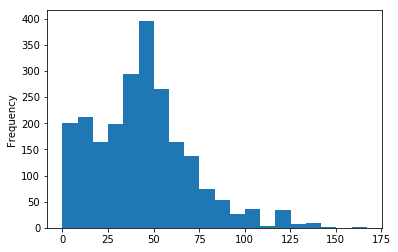

'firebird',


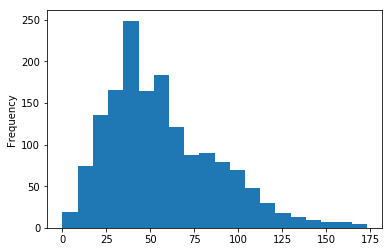

'monetdb',


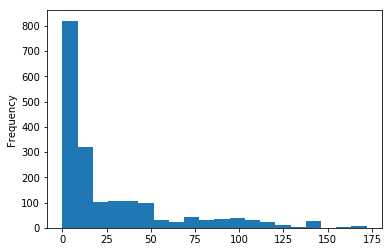

'mssql',


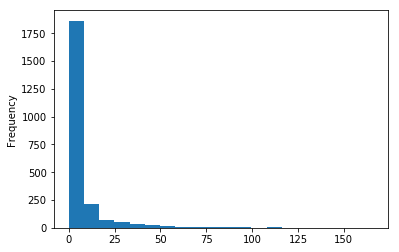

'mariadb',


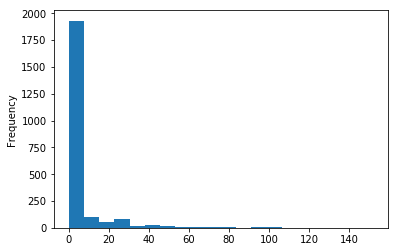

'oracle',


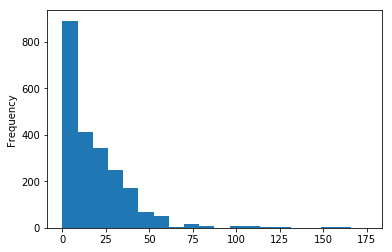

'pgsql',


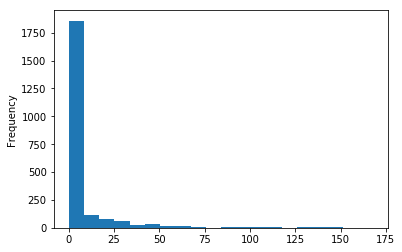

'sqltm',


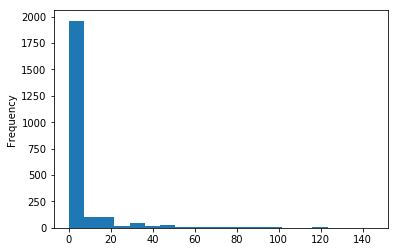

'teradata',


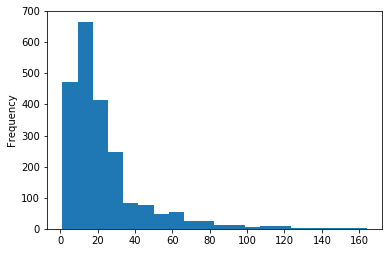

In [44]:
def to_float(x):
    try:
        return float(x)
    except:
        # print("PROBLEM_CONVERTING" , x)
        return None

import matplotlib.pyplot as plt
for dialect in dialects:
    print(dialect)
    df1 = df[df.est_dialect == dialect] # .sample(4000)
    times = df1['elapsed_time'].apply(to_float)
    # times= times[times > 100]
    times.plot(kind='hist' , bins=20)
    plt.show()
